In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
warnings.filterwarnings("ignore")
from IPython.display import display


In [2]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [8]:
def getAllUniqueModels():
    allModels = portfolio.getModels(ticker=None, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [9]:
uniqueModels = getAllUniqueModels()

***ORIGINAL MODELS***
((10, ('FXE', 2, None, None), 5, 'VTI'), 10, 250)
((10, ('IEF', 3, None, None), 3, 'EWT'), 10, 250)
((22, ('QQQ', 10, None, None), 2, 'EEM'), 22, 25)
((10, ('IJR', 34, None, 6), 3, 'ITB'), 10, 50)
((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((22, ('IVV', 4, 19, 9), 3, 'EWU'), 22, 50)
((10, ('EWT', 33, None, None), 3, 'XLY'), 10, 50)
((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)
((10, ('EWT', 33, None, None), 5, 'XLY'), 10, 100)
((10, ('IEF', 25, None, None), 5, 'VTI'), 10, 25)
((22, ('DXJ', 18, 16, 21), 5, 'VUG'), 22, 250)
((22, ('IEF', 27, None, 9), 3, 'IVW'), 22, 25)
((22, ('FXE', 29, 18, 19), 5, 'XLI'), 22, 25)
((10, ('EWH', 5, None, 10), 3, 'EWT'), 10, 100)
((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)
((22, ('VIG', 6, None, 12), 3, 'IJH'), 22, 25)
((22, ('GDX', 32, None, None), 2, 'EWZ'), 22, 50)
((10, ('VGK', 38, None, 16), 3, 'XLB'), 10, 100)
((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)
((22, ('XLV', 26, None, None), 5, 'OEF'), 22, 25)
((10, ('T

In [4]:
# uniqueModels = getUniqueModelsForTicker("EWZ") + getUniqueModelsForTicker("OEF")

***ORIGINAL MODELS***
((22, ('GDX', 32, None, None), 2, 'EWZ'), 22, 50)
((22, ('GDX', 32, None, None), 5, 'EWZ'), 22, 50)
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 25)
((22, ('GDX', 32, None, None), 2, 'EWZ'), 22, 250)
((10, ('GDX', 32, None, None), 5, 'EWZ'), 10, 25)
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((10, ('GDX', 32, None, None), 2, 'EWZ'), 10, 100)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 250)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)
***UNIQUE MODELS***
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
25TH PERCENTILE SHARPE 1.0421233172372808
ACTIVITY 0.8867719107240065
ALPHA 0.31536348810292847
ANNUALIZED RETURN 0.35303400909922455
BETA 0.2512840443703012
MIN ROLLING SHARPE -0.06045637955271487
OOS_ACTIVITY 0.8571428571428571
OOS_ALPHA 0.2208964646675671
OOS_ANNUALIZED RETURN 0.2183005334647803
OOS_BETA 0.017703288037019396
OOS_RAW BETA 0.05148741418764301
OOS_SHARPE 1.0940734507376269
OOS_STABILITY 0.19187004910345523
OOS_TREYNOR 3.305818781360

In [5]:
def computeReturnsForUniqueModels(uniqueModels, factorToTrade):
    tickersRequired = []
    tickersTraded = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
        if mod.inputSeries.series.ticker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.series.ticker)
        if mod.inputSeries.targetTicker not in tickersTraded:
            tickersTraded.append(mod.inputSeries.targetTicker)

    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions = portfolioGeneration.generateAllReturns(uniqueModels, joinedData)
    
    return modelReturns, modelPredictions, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [62]:
factorToTrade = "SPY"
modelReturns, modelPredictions, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModels(uniqueModels, factorToTrade)

((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)
((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)
((22, ('TIP', 29, None, None), 3, 'OEF'), 22, 25)
GDX
EWZ
TIP
OEF
XLV
SPY
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
THREAD  1 PROGRESS: 0.8333333333333334
THREAD  2 PROGRESS: 0.8333333333333334
THREAD  0 PROGRESS: 0.8333333333333334
THREAD  3 PROGRESS: 0.8333333333333334
THREAD  6 PROGRESS: 0.8333333333333334
THREAD  7 PROGRESS: 0.8333333333333334
THREAD  5 PROGRESS: 0.8333333333333334
THREAD  10 PROGRESS: 0.8333333333333334
THREAD  4 PROGRESS: 0.8333333333333334
THREAD  32 PROGRESS: 0.8571428571428571
THREAD  8 PROGRESS: 0.8333333333333334
THREAD  9 PROGRESS: 0.8333333333333334
THREAD  11 PROGRESS: 0.8333333333333334
THREAD  15 PROGRESS: 0.8333333333333334
THREAD  17 PROGRESS: 0.8333333333333334
THREAD  12 PROGRESS: 0.8333333333333334
THREAD  13 PROGRESS: 0.8333333333333334
THREAD  14 PROGRESS: 0.8333333333333334
THREAD  16 PRO

Process ForkProcess-1135:
Process ForkProcess-1122:
Process ForkProcess-1136:
Process ForkProcess-1139:
Process ForkProcess-1142:
Process ForkProcess-1124:
Process ForkProcess-1126:
Process ForkProcess-1144:
Process ForkProcess-1137:
Process ForkProcess-1145:
Process ForkProcess-1151:
Process ForkProcess-1147:
Process ForkProcess-1143:
Process ForkProcess-1149:
Process ForkProcess-1140:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-1150:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  Fi

KeyboardInterrupt: 

  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/ho

In [48]:
##600 DAY DELAY BECAUSE OF MINIMUM PREDICTION REQUIREMENT
display(modelPredictions)

,"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)","((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)","((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)","((22, ('TIP', 29, None, None), 3, 'OEF'), 22, 25)"
2009-03-02,0.00,0.50,0.5,1.0
2009-03-03,-0.25,1.00,0.0,1.0
2009-03-04,0.00,1.00,0.0,0.5
2009-03-05,0.25,0.50,-0.5,0.5
2009-03-06,0.50,0.50,0.0,0.5
2009-03-09,1.00,0.50,0.0,0.5
2009-03-10,1.00,0.00,-0.5,0.5
2009-03-11,1.00,0.50,0.0,0.0
2009-03-12,1.00,0.25,-0.5,0.0
2009-03-13,1.00,-0.25,0.0,0.0


,"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)","((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)","((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)","((22, ('TIP', 29, None, None), 3, 'OEF'), 22, 25)",Factor Return
"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)",1.000000,0.443176,0.097009,0.123695,0.288384
"((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)",0.443176,1.000000,0.074859,0.117513,0.278151
"((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)",0.097009,0.074859,1.000000,0.074248,0.137348
"((22, ('TIP', 29, None, None), 3, 'OEF'), 22, 25)",0.123695,0.117513,0.074248,1.000000,0.309745
Factor Return,0.288384,0.278151,0.137348,0.309745,1.000000


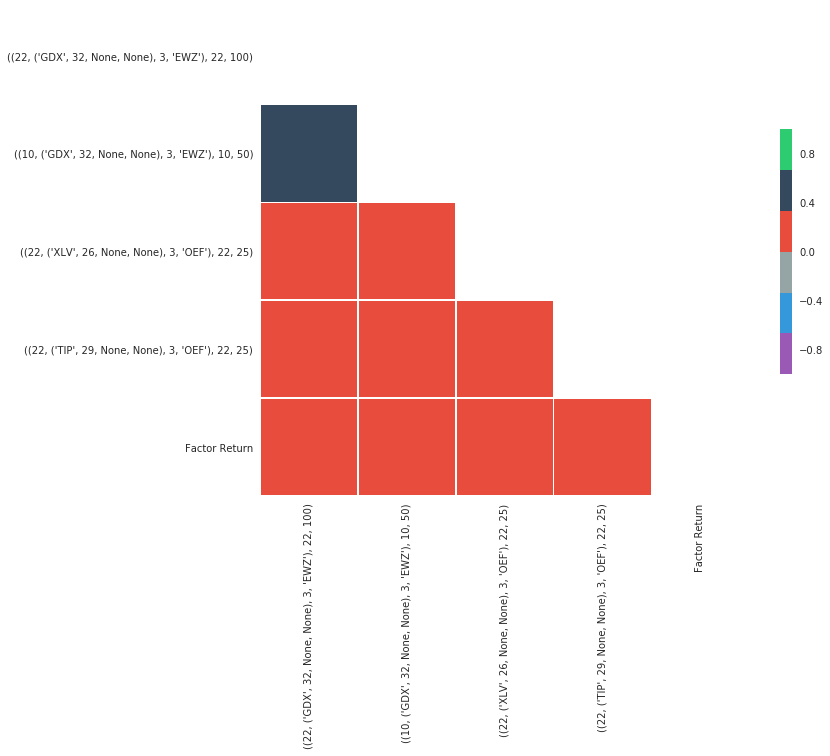

,"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)","((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)","((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)","((22, ('TIP', 29, None, None), 3, 'OEF'), 22, 25)",Factor Return
"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)",0.000209,0.000085,0.000009,0.000010,0.000042
"((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)",0.000085,0.000175,0.000006,0.000009,0.000037
"((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)",0.000009,0.000006,0.000038,0.000003,0.000009
"((22, ('TIP', 29, None, None), 3, 'OEF'), 22, 25)",0.000010,0.000009,0.000003,0.000034,0.000018
Factor Return,0.000042,0.000037,0.000009,0.000018,0.000102


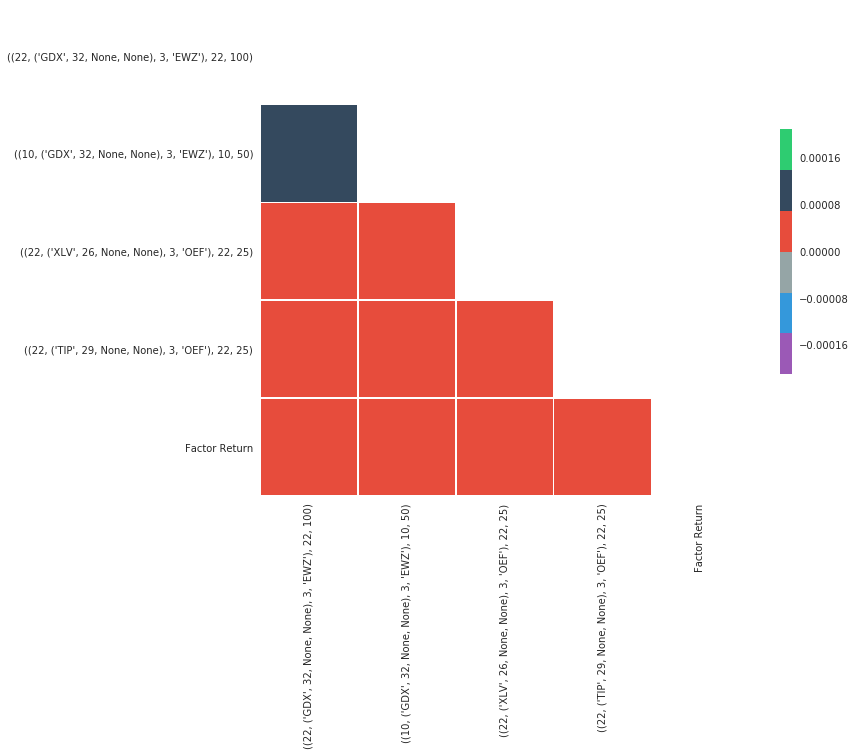

In [8]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [9]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)
((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)
((22, ('TIP', 29, None, None), 3, 'OEF'), 22, 25)


In [10]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="First Combo Trade Test vs SPY", benchmark=factorToTrade)

PORTFOLIO HASH: 1e0c232022c226ff39f67cc3e0686593237394f1989b2c08e76d0a21
4018e7b6f84216af0c0b942847d8ee439f42a184fcc9a0ccea90f212
736666aec4fadbeac073674a18f5702bd69156f73b8649077cb59c05
bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e
e1111d514a667ab22d8f48a2734a7dab0be1350f8ce70ca3b8a172ac


In [29]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
display(modelHashes)

['4018e7b6f84216af0c0b942847d8ee439f42a184fcc9a0ccea90f212',
 '736666aec4fadbeac073674a18f5702bd69156f73b8649077cb59c05',
 'bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e',
 'e1111d514a667ab22d8f48a2734a7dab0be1350f8ce70ca3b8a172ac']

In [30]:
allModels = portfolio.getModelsByKey(modelHashes)
display(allModels)

In [31]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
display(aggregateReturns)

,736666aec4fadbeac073674a18f5702bd69156f73b8649077cb59c05,4018e7b6f84216af0c0b942847d8ee439f42a184fcc9a0ccea90f212,bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e,e1111d514a667ab22d8f48a2734a7dab0be1350f8ce70ca3b8a172ac
2009-03-02,-0.005042,-0.002521,0.000000,0.006808
2009-03-03,0.015541,0.000000,-0.017631,0.070522
2009-03-04,-0.018796,-0.000000,-0.000000,-0.026490
2009-03-05,0.001383,-0.001383,-0.000537,-0.001074
2009-03-06,-0.005343,-0.000000,-0.006638,-0.006638
2009-03-09,0.029268,0.000000,0.078182,0.039091
2009-03-10,0.002633,-0.002633,-0.002361,-0.000000
2009-03-11,0.000000,0.000000,0.032116,0.016058
2009-03-12,0.000000,-0.004093,-0.006223,-0.001556
2009-03-13,-0.000000,-0.000000,-0.007910,0.001978


In [1]:
import importlib
importlib.reload(portfolioGeneration)

NameError: name 'portfolioGeneration' is not defined

In [ ]:
hrpReturns, historicalWeights = portfolioGeneration.\
    produceHRPPredictions(aggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
    22, startIndex=None, maxWindowSize=True)
print("COMPUTED HISTORICAL WEIGHTS")
display(historicalWeights)
portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                allModels, historicalWeights, aggregatePredictions)

COMPUTED HISTORICAL WEIGHTS


,4018e7b6f84216af0c0b942847d8ee439f42a184fcc9a0ccea90f212,736666aec4fadbeac073674a18f5702bd69156f73b8649077cb59c05,bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e,e1111d514a667ab22d8f48a2734a7dab0be1350f8ce70ca3b8a172ac
2009-04-01,0.286352,0.373402,0.227040,0.113206
2009-04-02,0.270717,0.379945,0.219400,0.129937
2009-04-03,0.154381,0.464836,0.168246,0.212536
2009-04-06,0.139560,0.488081,0.155198,0.217162
2009-04-07,0.135551,0.484176,0.159338,0.220935
2009-04-08,0.132723,0.485073,0.163024,0.219181
2009-04-09,0.067259,0.567540,0.226417,0.138784
2009-04-13,0.067266,0.567127,0.226823,0.138784
2009-04-14,0.063278,0.559238,0.246802,0.130682
2009-04-15,0.062827,0.554552,0.251133,0.131488


In [43]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData)
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData)

{'key': '1e0c232022c226ff39f67cc3e0686593237394f1989b2c08e76d0a21', 'description': 'First Combo Trade Test vs SPY', 'benchmark': 'SPY'}
((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)
((22, ('TIP', 29, None, None), 3, 'OEF'), 22, 25)
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)
